# Integrating Neural Networks with Flux.jl

In this example, our focus is on Bayesian state estimation in a Nonlinear State-Space Model. Specifically, we will utilize the time series generated by the [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system) as an example. 

Our objective is to compute the marginal posterior distribution of the latent (hidden) state $x_k$ at each time step $k$, considering the history of measurements up to that time step:

$$p(x_k | y_{1:k}).$$

The above expression represents the probability distribution of the latent state $x_k$ given the measurements $y_{1:k}$ up to time step $k$.

In [1]:
using RxInfer, BenchmarkTools, Flux, ReverseDiff, Random, Plots, LinearAlgebra, ProgressMeter, JLD, StableRNGs

### Generate data

In [5]:
# Lorenz system equations to be used to generate dataset
Base.@kwdef mutable struct Lorenz
    dt::Float64
    σ::Float64
    ρ::Float64
    β::Float64
    x::Float64
    y::Float64
    z::Float64
end

function step!(l::Lorenz)
    dx = l.σ * (l.y - l.x);         l.x += l.dt * dx
    dy = l.x * (l.ρ - l.z) - l.y;   l.y += l.dt * dy
    dz = l.x * l.y - l.β * l.z;     l.z += l.dt * dz
end
;

In [28]:
function create_dataset(rng, σ, ρ, β_nom; n_steps = 100, p_train = 0.6, p_valid = 0.2, p_test = 0.2)
    attractor = Lorenz(0.02, σ, ρ, β_nom/3.0, 1, 1, 1)
    signal       = [Float32[1.0, 1.0, 1.0]]
    noisy_signal = [last(signal) + randn(rng, Float32, 3)]
    for i in 1:(n_steps - 1)
        step!(attractor)
        push!(signal, [attractor.x, attractor.y, attractor.z])
        push!(noisy_signal, last(signal) + randn(rng, 3))
    end

    n_train = floor(Int, n_steps * p_train)
    n_valid = floor(Int, n_steps * p_valid)
    n_test  = n_steps - n_train - n_valid
    train_data = signal[1:n_train]
    valid_data = signal[n_train+1:n_train+n_valid]
    test_data  = signal[n_train+n_valid+1:end]
    train_noisy_data = noisy_signal[1:n_train]
    valid_noisy_data = noisy_signal[n_train+1:n_train+n_valid]
    test_noisy_data  = noisy_signal[n_train+n_valid+1:end]

    return (
        parameters = (σ, ρ, β_nom),
        train = train_data, 
        valid = valid_data, 
        test = test_data, 
        train_noisy = train_noisy_data, 
        valid_noisy = valid_noisy_data, 
        test_noisy = test_noisy_data
    )
end

create_dataset (generic function with 1 method)

In [36]:
# Dataset
rng = StableRNG(999)

dataset = create_dataset(rng, 11, 23, 6; n_steps = 1000);

### Data visualization

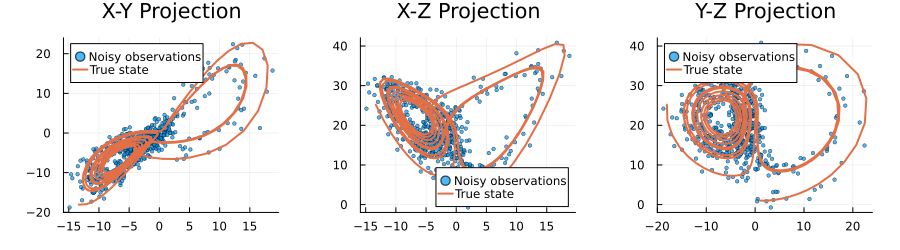

In [52]:
# Extract first samples from datasets
sample_clean = dataset.train
sample_noisy = dataset.train_noisy

# Pre-allocate arrays for better performance
n_points = length(sample_clean)
gx, gy, gz = zeros(n_points), zeros(n_points), zeros(n_points)
rx, ry, rz = zeros(n_points), zeros(n_points), zeros(n_points)

# Extract coordinates
for i in 1:n_points
    # Noisy observations
    rx[i], ry[i], rz[i] = sample_noisy[i][1], sample_noisy[i][2], sample_noisy[i][3]
    # True state
    gx[i], gy[i], gz[i] = sample_clean[i][1], sample_clean[i][2], sample_clean[i][3]
end

# Create three projection plots
p1 = scatter(rx, ry, label="Noisy observations", alpha=0.7, markersize=2, title = "X-Y Projection")
plot!(p1, gx, gy, label="True state", linewidth=2)

p2 = scatter(rx, rz, label="Noisy observations", alpha=0.7, markersize=2, title = "X-Z Projection")
plot!(p2, gx, gz, label="True state", linewidth=2)

p3 = scatter(ry, rz, label="Noisy observations", alpha=0.7, markersize=2, title = "Y-Z Projection")
plot!(p3, gy, gz, label="True state", linewidth=2)

# Combine plots with improved layout
plot(p1, p2, p3, size=(900, 250), layout=(1,3), margin=5Plots.mm)

### Inference

We use the following state-space model representation:

$$\begin{aligned}
x_k \sim p(x_k | x_{k-1}) \\
y_k \sim p(y_k | x_k).
\end{aligned}$$

where $x_k \sim p(x_k | x_{k-1})$ represents the hidden dynamics of our system. 
The hidden dynamics of the Lorenz system exhibit nonlinearities and hence cannot be solved in the closed form.
One manner of solving this problem is by introducing a neural network to approximate the transition matrix of the Lorenz system. 

$$\begin{aligned}
A_{k-1}=NN(y_{k-1}) \\
p(x_k | x_{k-1})=\mathcal{N}(x_k | A_{k-1}x_{k-1}, Q) \\
p(y_k | x_k)=\mathcal{N}(y_k | Bx_k, R)
\end{aligned}$$

where $NN$ is the neural network. The input is the observation $y_{k-1}$, and output is the trasition matrix $A_{k-1}$.
$B$ denote distortion or measurment matrix. $Q$ and $R$ are covariance matrices. Note that the hidden state $x_k$ comprises three coordinates, i.e. $x_k = (rx_k, ry_k, rz_k)$

By employing this state-space model representation and utilizing the neural network approximation, we can estimate the hidden dynamics and perform inference in the Lorenz system.

In [38]:
function make_neural_network()
    InputLayer = Dense(3 => 5, relu)
    OutputLayer = Dense(5 => 3)
    return Chain(InputLayer, OutputLayer)
end

make_neural_network (generic function with 1 method)

In [39]:
nn = make_neural_network()

Chain(
  Dense(3 => 5, relu),                  # 20 parameters
  Dense(5 => 3),                        # 18 parameters
)                   # Total: 4 arrays, 38 parameters, 360 bytes.

### Model specification
Note that we treat the trasition matrix $A_{k-1}$ as time-varying.

In [42]:
#State Space Model
@model function ssm(y, As, Q, B, R)
    
    x_prior_mean = zeros(3)
    x_prior_cov  = Matrix(Diagonal(ones(3)))
    
    x[1] ~ MvNormal(mean = x_prior_mean, cov = x_prior_cov)
    y[1] ~ MvNormal(mean = B * x[1], cov = R)
    
    for i in 2:length(y)
        x[i] ~ MvNormal(mean = As[i - 1] * x[i - 1], cov = Q) 
        y[i] ~ MvNormal(mean = B * x[i], cov = R)
    end
end

We set distortion matrix $B$ and the covariance matrices $Q$ and $R$ as identity matrix.

In [43]:
Q = Matrix(Diagonal(ones(3)))*2
B = Matrix(Diagonal(ones(3)))
R = Matrix(Diagonal(ones(3)))
;

We use the *inference* function in the **RxInfer.jl**. Before that, we need to bulid a function to get the matrix $A$ output by the neural network. And the $A$ is treated as a datavar in the inference function.

In [44]:
function get_matrix_AS(data, nn)
    dd = hcat(data[1:end-1]...)
    As = nn(dd)
    return map(c -> Matrix(Diagonal(c)), eachcol(As))
end

get_matrix_AS (generic function with 1 method)

Before network training, we show the inference results for the hidden states:

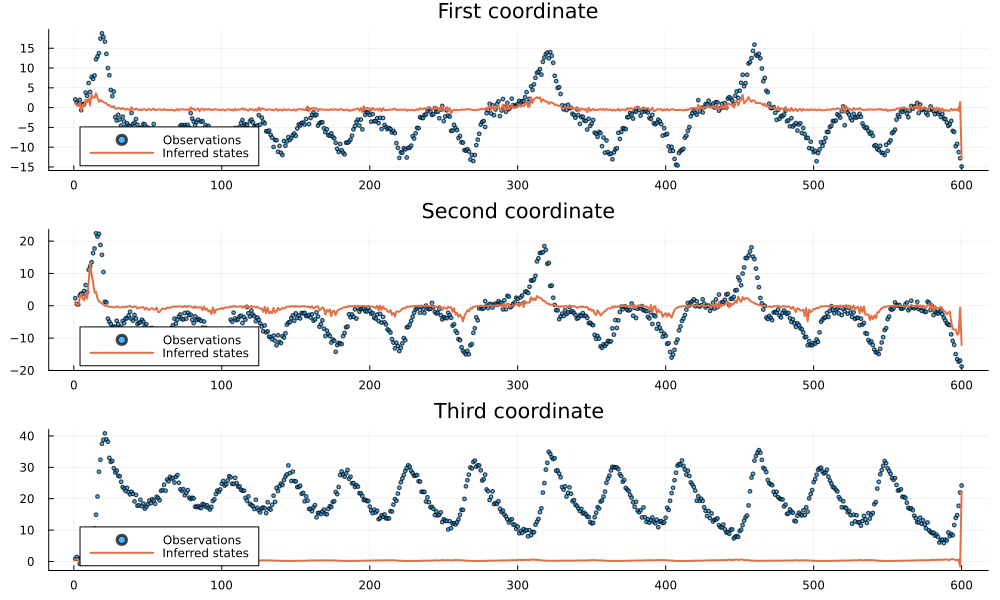

In [59]:
# Performance on an instance from the testset before training
untrained_neural_network = make_neural_network()
untrained_transition_matrices = get_matrix_AS(dataset.train_noisy, untrained_neural_network)

result = infer(
    model = ssm(As = untrained_transition_matrices, Q = Q, B = B, R = R), 
    data  = (y = dataset.train_noisy, ), 
    returnvars = (x = KeepLast(), )
)

p1 = scatter(getindex.(dataset.train_noisy, 1), label="Observations", alpha=0.7, markersize=2, title = "First coordinate")
plot!(getindex.(mean.(result.posteriors[:x]), 1), label="Inferred states", linewidth=2)

p2 = scatter(getindex.(dataset.train_noisy, 2), label="Observations", alpha=0.7, markersize=2, title = "Second coordinate")
plot!(getindex.(mean.(result.posteriors[:x]), 2), label="Inferred states", linewidth=2)

p3 = scatter(getindex.(dataset.train_noisy, 3), label="Observations", alpha=0.7, markersize=2, title = "Third coordinate")
plot!(getindex.(mean.(result.posteriors[:x]), 3), label="Inferred states", linewidth=2)

plot(p1, p2, p3, size = (1000, 600), layout = (3, 1), legend=:bottomleft)


### Training network

In this part, we use the Free Energy as the objective function to optimize the weights of network.

In [60]:
# free energy objective to be optimized during training
function make_fe_tot_est(rebuild, data; Q = Q, B = B, R = R)
    function fe_tot_est(v)
        nn = rebuild(v)
        result = infer(
            model = ssm(As = get_matrix_AS(data, nn), Q = Q, B = B, R = R), 
            data  = (y = data, ), 
            returnvars = (x = KeepLast(), ),
            free_energy = true,
            session = nothing
        )
        return result.free_energy[end]
    end
end

make_fe_tot_est (generic function with 2 methods)

# Training

In [61]:
# Training is a computationally expensive procedure, for the sake of an example we load pre-trained weights
# Uncomment the following code to train the network manually
function train!(neural_network, data; num_epochs = 100)
    rule = Flux.Optimise.Descent(0.01)
    state = Flux.Optimise.setup(rule, neural_network)

    x, rebuild = Flux.destructure(neural_network)
    fe_tot_est_ = make_fe_tot_est(rebuild, data)

    run_epochs!(rebuild, fe_tot_est_, state, neural_network; num_epochs = num_epochs)
end

function run_epochs!(rebuild::F, fe_tot_est::I, state::S, neural_network::N; num_epochs::Int = 100) where {F, I, S, N}
    @showprogress for epoch in 1:num_epochs
        flat, _ = Flux.destructure(neural_network)
        grads = ReverseDiff.gradient(fe_tot_est, flat);
        Flux.update!(state, neural_network, rebuild(grads))
    end
end

run_epochs! (generic function with 1 method)

In [ ]:
trained_neural_network = make_neural_network()
train!(trained_neural_network, dataset.train_noisy; num_epochs = 100)

Progress:  36%|██████████████▊                          |  ETA: 0:01:22

In [31]:
1

1

### Test

Import the weights of neural network that we have trained.

In [32]:
W1a, b1a, W2_1a, W2_2a, b2a, s2_1a, W3, b3a = load("nn_prediction/weights.jld")["data"];

In [33]:
# Performance on an instance from the testset after training
index = 1
data = testset[index]
n = length(data)
result = infer(
    model = ssm(As = get_matrix_AS(data, neural_network), Q = Q, B = B,R = R), 
    data  = (y = data, ), 
    returnvars = (x = KeepLast(), ),
    free_energy = true
)
x_est=result.posteriors[:x]

gx, gy, gz = zeros(100), zeros(100), zeros(100)
rx, ry, rz = zeros(100), zeros(100), zeros(100)
rx_est_m, ry_est_m, rz_est_m = zeros(100), zeros(100), zeros(100)
rx_est_var, ry_est_var, rz_est_var = zeros(100), zeros(100), zeros(100)

for i=1:100
    gx[i], gy[i], gz[i] = noise_free_testset[index][i][1], noise_free_testset[index][i][2], noise_free_testset[index][i][3]
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mean(x_est[i])[1], mean(x_est[i])[2], mean(x_est[i])[3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = var(x_est[i])[1], var(x_est[i])[2], var(x_est[i])[3]
end

p1 = plot(rx,label="Hidden state rx")
p1 = plot!(rx_est_m,label="Inferred states", ribbon=rx_est_var)
p1 = scatter!(first.(testset[index]), label="Observations", markersize=1.0)

p2 = plot(ry,label="Hidden state ry")
p2 = plot!(ry_est_m,label="Inferred states", ribbon=ry_est_var)
p2 = scatter!(getindex.(testset[index], 2), label="Observations", markersize=1.0)

p3 = plot(rz,label="Hidden state rz")
p3 = plot!(rz_est_m,label="Inferred states", ribbon=rz_est_var)
p3 = scatter!(last.(testset[index]), label="Observations", markersize=1.0)

plot(p1, p2, p3, size = (1000, 300))

UndefVarError: UndefVarError: `neural_network` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### Prediction

In the above instances, the observations during whole time are available. For prediction task, we can only access to the  observations untill $k$ and estimate the future state at time $k+1$, $k+2$, $\dots$,$k+T$.

We can still solve this problem by the trained neural network to approximate the transition matrix. And we can get the one-step prediction in the future. Then, the predicted results are feed into the neural network to generate the transition matrix for the next step, and roll into the future to get the multi-step prediction.

$$\begin{aligned}
A_{k}=NN(x_{k}) \\
p(x_{k+1} | x_{k})=\mathcal{N}(x_{k+1} | A_{k}x_{k}, Q) \\
\end{aligned}$$

In [34]:
#Define the prediction function
multiplyGaussian(A,m,V) = (A * m, A * V * transpose(A))
sumGaussians(m1,m2,V1,V2) = (m1 + m2, V1 + V2)

function runForward(A,B,Q,R,mh_old,Vh_old)
    mh_1, Vh_1 = multiplyGaussian(A,mh_old,Vh_old)
    mh_pred, Vh_pred = sumGaussians(mh_1, zeros(length(mh_old)), Vh_1, Q)
end

function g_predict(mh_old,Vh_old,Q)
    neural = NN(W1a,b1a,W2_1a,W2_2a,b2a,s2_1a,W3,b3a)
    # Flux.reset!(neural)
    As  = map((d) -> Matrix(Diagonal(neural.g(d))), [mh_old])
    As = As[1]
    return runForward(As,B,Q,R,mh_old,Vh_old), As
end

g_predict (generic function with 1 method)

After $k=75$, the observations are not available, and we predict the future state from $k=76$ to the end

In [35]:
tt = 75
mh = mean(x_est[tt])
Vh = cov(x_est[tt])
mo_list, Vo_list, A_list = [], [], [] 
inv_Q = inv(Q)
for t=1:100-tt
    (mo, Vo), A_t = g_predict(mh,Vh,inv_Q)
    push!(mo_list, mo)
    push!(Vo_list, Vh)
    push!(A_list, A_t)
    global mh = mo
    global Vh = Vo
end


UndefVarError: UndefVarError: `NN` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [36]:
# Prediction visualization
rx, ry, rz = zeros(100), zeros(100), zeros(100)
rx_est_m, ry_est_m, rz_est_m = zeros(100), zeros(100), zeros(100)
rx_est_var, ry_est_var, rz_est_var = zeros(100), zeros(100), zeros(100)
for i=1:tt
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mean(x_est[i])[1], mean(x_est[i])[2], mean(x_est[i])[3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = var(x_est[i])[1], var(x_est[i])[2], var(x_est[i])[3]
end
for i=tt+1:100
    ii=i-tt
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mo_list[ii][1], mo_list[ii][2], mo_list[ii][3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = Vo_list[ii][1,1], Vo_list[ii][2,2], Vo_list[ii][3,3]
end
p1 = plot(rx,label="Ground truth rx")
p1 = plot!(rx_est_m,label="Inffered state rx",ribbon=rx_est_var)
p1 = scatter!(first.(testset[index][1:tt]), label="Observations", markersize=1.0)

p2 = plot(ry,label="Ground truth ry")
p2 = plot!(ry_est_m,label="Inferred states", ribbon=ry_est_var)
p2 = scatter!(getindex.(testset[index][1:tt], 2), label="Observations", markersize=1.0)

p3 = plot(rz,label="Ground truth rz")
p3 = plot!(rz_est_m,label="Inferred states", ribbon=rz_est_var)
p3 = scatter!(last.(testset[index][1:tt]), label="Observations", markersize=1.0)


plot(p1, p2, p3, size = (1000, 300),legend=:bottomleft)

BoundsError: BoundsError: attempt to access 0-element Vector{Any} at index [1]